In [1]:
import torch 
import numpy as np

from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler

from data.budworm import simulate_trials
from stabnode.utils import set_global_seed
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('ggplot')


seed = 1234
set_global_seed(seed=seed)


savefigs = False
folder = "g_true/"

In [2]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)
print(r1,r2)

k1 = r1-1.1
k2 = r2+1.1

def smooth_k(t):
    A = (k2-k1)/2
    return A*np.sin(t-np.pi/2)+A + k1

def smooth_k_torch(t):
    A = (k2-k1)/2
    return A*torch.sin(t-torch.pi/2) + A + k1

6.44569072482332 9.93441120446710


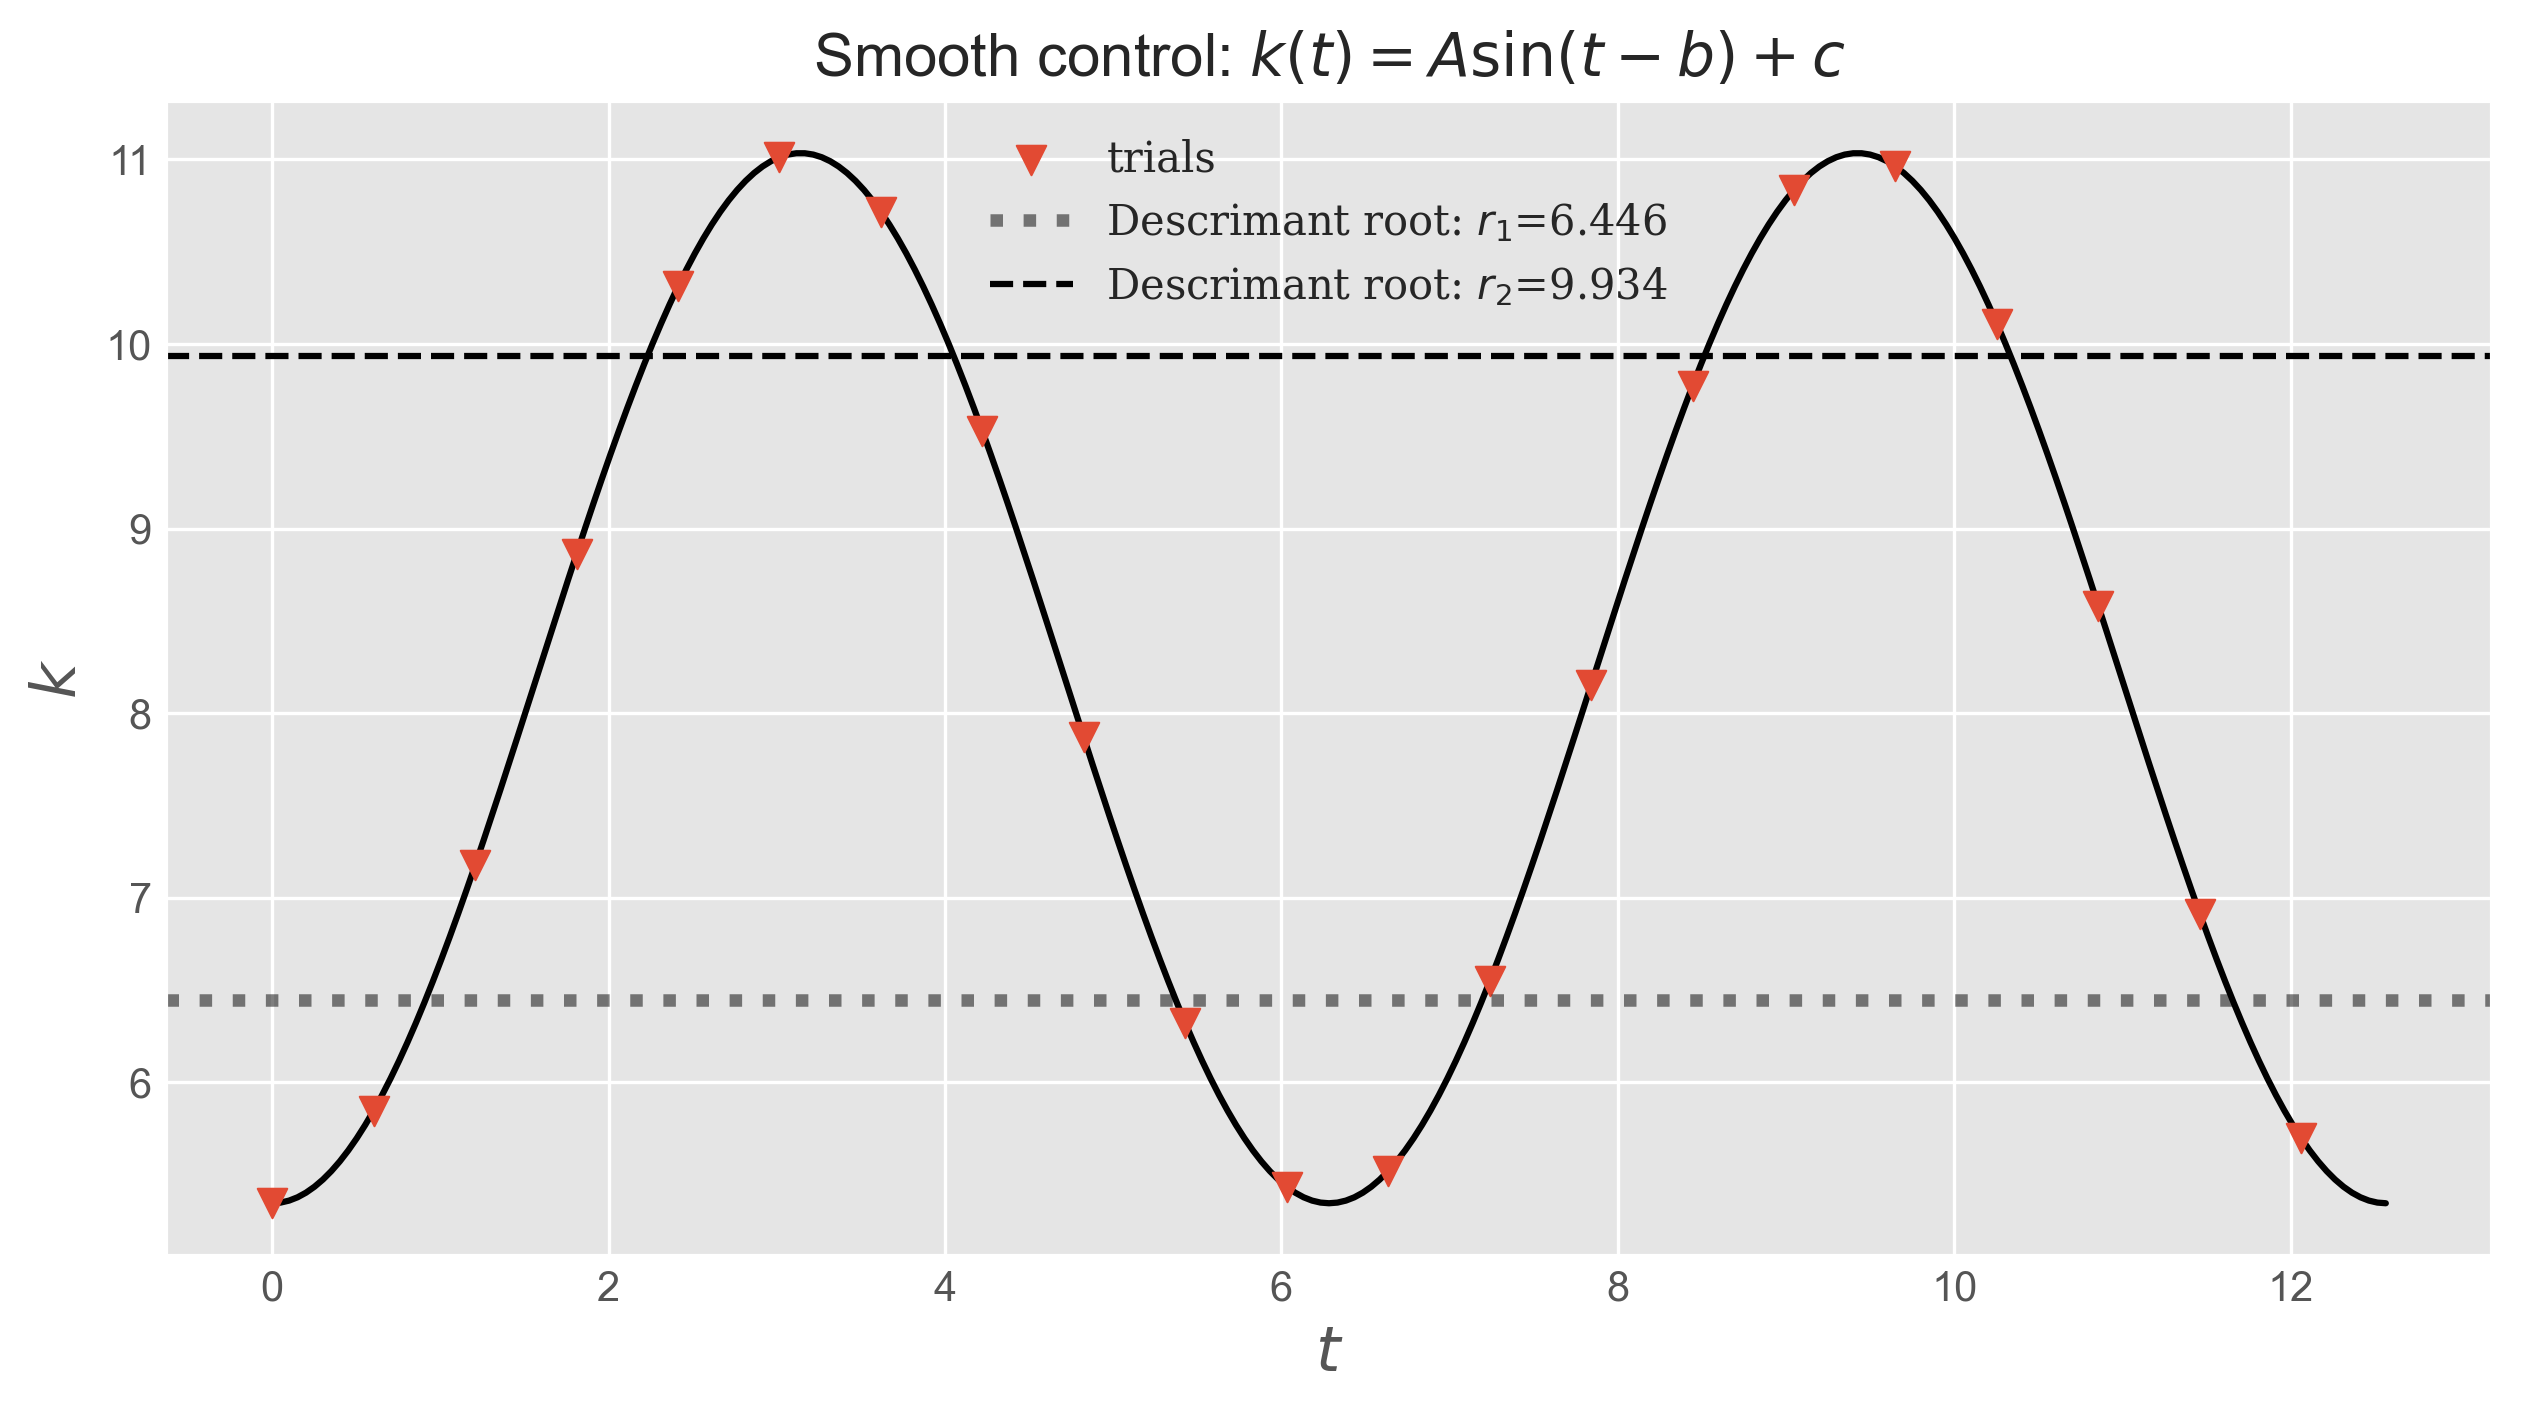

In [3]:
sample_rate = 12
t_span = np.linspace(0,4*np.pi,251)
t_trials = t_span[::sample_rate]
k_true = smooth_k(t_span)
k_trials = smooth_k(t_trials)


fig, ax = plt.subplots(1,1,figsize=(10,5),dpi=300)
t_span = np.linspace(0,4*np.pi,251)

ax.plot(t_span, k_true,c='black',zorder=1)
ax.scatter(
    t_span[::sample_rate],
    k_trials,
    label='trials',
    marker='v',
    s=50,
    zorder=2
)
ax.grid(True)
ax.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=3)
ax.axhline(r2, linestyle='--',c='black', label=rf"Descrimant root: $r_2$={r2:.3f}")
ax.set_ylabel(r"$k$", size=15)
ax.set_xlabel(r"$t$",size=15)
ax.set_title(r"Smooth control: $k(t) = A\sin(t-b)+c$")
ax.legend(prop={'family':'serif'})
if savefigs:
    plt.savefig(folder+f"budworm_smooth_control_{len(k_trials)}_k_trials.pdf")
plt.grid(True)
plt.show()

In [4]:
from data.budworm import budworm_steady_states

xs = np.linspace(0.1,10,51)
trial = 2
ki = k_trials[trial]

ki, budworm_steady_states(ki,r=0.56)

(7.17628718783302, [0.8511783756957565, 1.9092596815699583, 4.415849130567294])

In [5]:
ki_trials = []
ki_times= []

for x0 in tqdm(xs):
    trials = simulate_trials([ki],x0,dt=0.2,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501,show_progress=False)
    ti = trials.t_vals[0]
    xi = trials.x_vals[0]

    ki_trials.append(xi)
    ki_times.append(ti)

  0%|          | 0/51 [00:00<?, ?it/s]

0it [00:00, ?it/s]

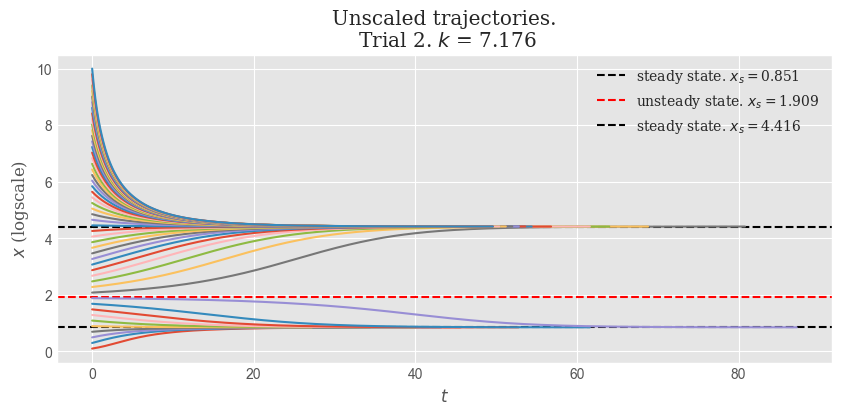

In [6]:
plt.figure(figsize=(10,4))
for xi, ti in tqdm(zip(ki_trials, ki_times)):
    plt.plot(ti,xi,zorder=2)


for idx,xsi in enumerate(budworm_steady_states(ki,r=0.56)):
    label = rf"steady state. $x_s=${xsi:.3f}"
    color = 'black'
    if idx ==1:
        label = rf"unsteady state. $x_s=${xsi:.3f}"
        color = 'red'

    plt.axhline(
        xsi,
        xmin=0,
        c=color,
        linestyle="--",
        label=label,
        zorder=1
    )


plt.legend(prop={'family':'serif'})
# plt.yscale('log')
plt.ylabel(r"$x$ (logscale)", family='serif')
plt.xlabel(r"$t$")
plt.title("Unscaled trajectories.\n" + rf" Trial {trial}. $k$ = {ki:.3f}", family='serif')
if savefigs:
    file_name = f"unscaled_trajectories_k_{ki:.2f}_num_x0_{len(xs)}.pdf"
    plt.savefig(folder+file_name)

plt.show()


In [7]:
scaler = MinMaxScaler()

scaler.fit(np.concatenate(ki_trials).reshape(-1,1))

scaled_trials = [
    scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in ki_trials
]

In [ ]:
scaled_steady_states = scaler.transform(np.array(budworm_steady_states(ki,r=0.56)).reshape(-1,1)).reshape(-1)

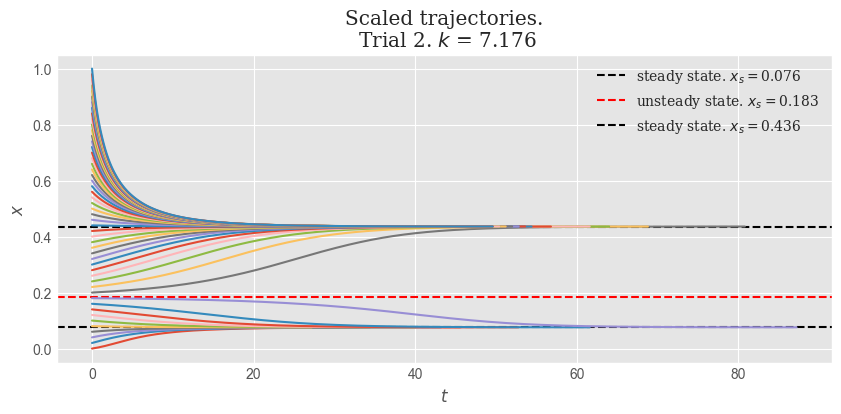

In [9]:
plt.figure(figsize=(10,4))
for xi, ti in zip(scaled_trials, ki_times):
    plt.plot(ti,xi)

for idx,xsi in enumerate(scaled_steady_states):
    label = rf"steady state. $x_s=${xsi:.3f}"
    color = 'black'
    if idx ==1:
        label = rf"unsteady state. $x_s=${xsi:.3f}"
        color = 'red'

    plt.axhline(
        xsi,
        xmin=0,
        c=color,
        linestyle="--",
        label=label,
        zorder=1
    )

plt.legend(prop={'family':'serif'})
plt.ylabel(r"$x$ ", family='serif')
plt.xlabel(r"$t$")
plt.title("Scaled trajectories.\n" + rf" Trial {trial}. $k$ = {ki:.3f}", family='serif')

plt.show()

# Plot all g_true

In [10]:
from data.budworm import g_true

In [11]:
x_lin = np.linspace(0,1,101)
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).squeeze()

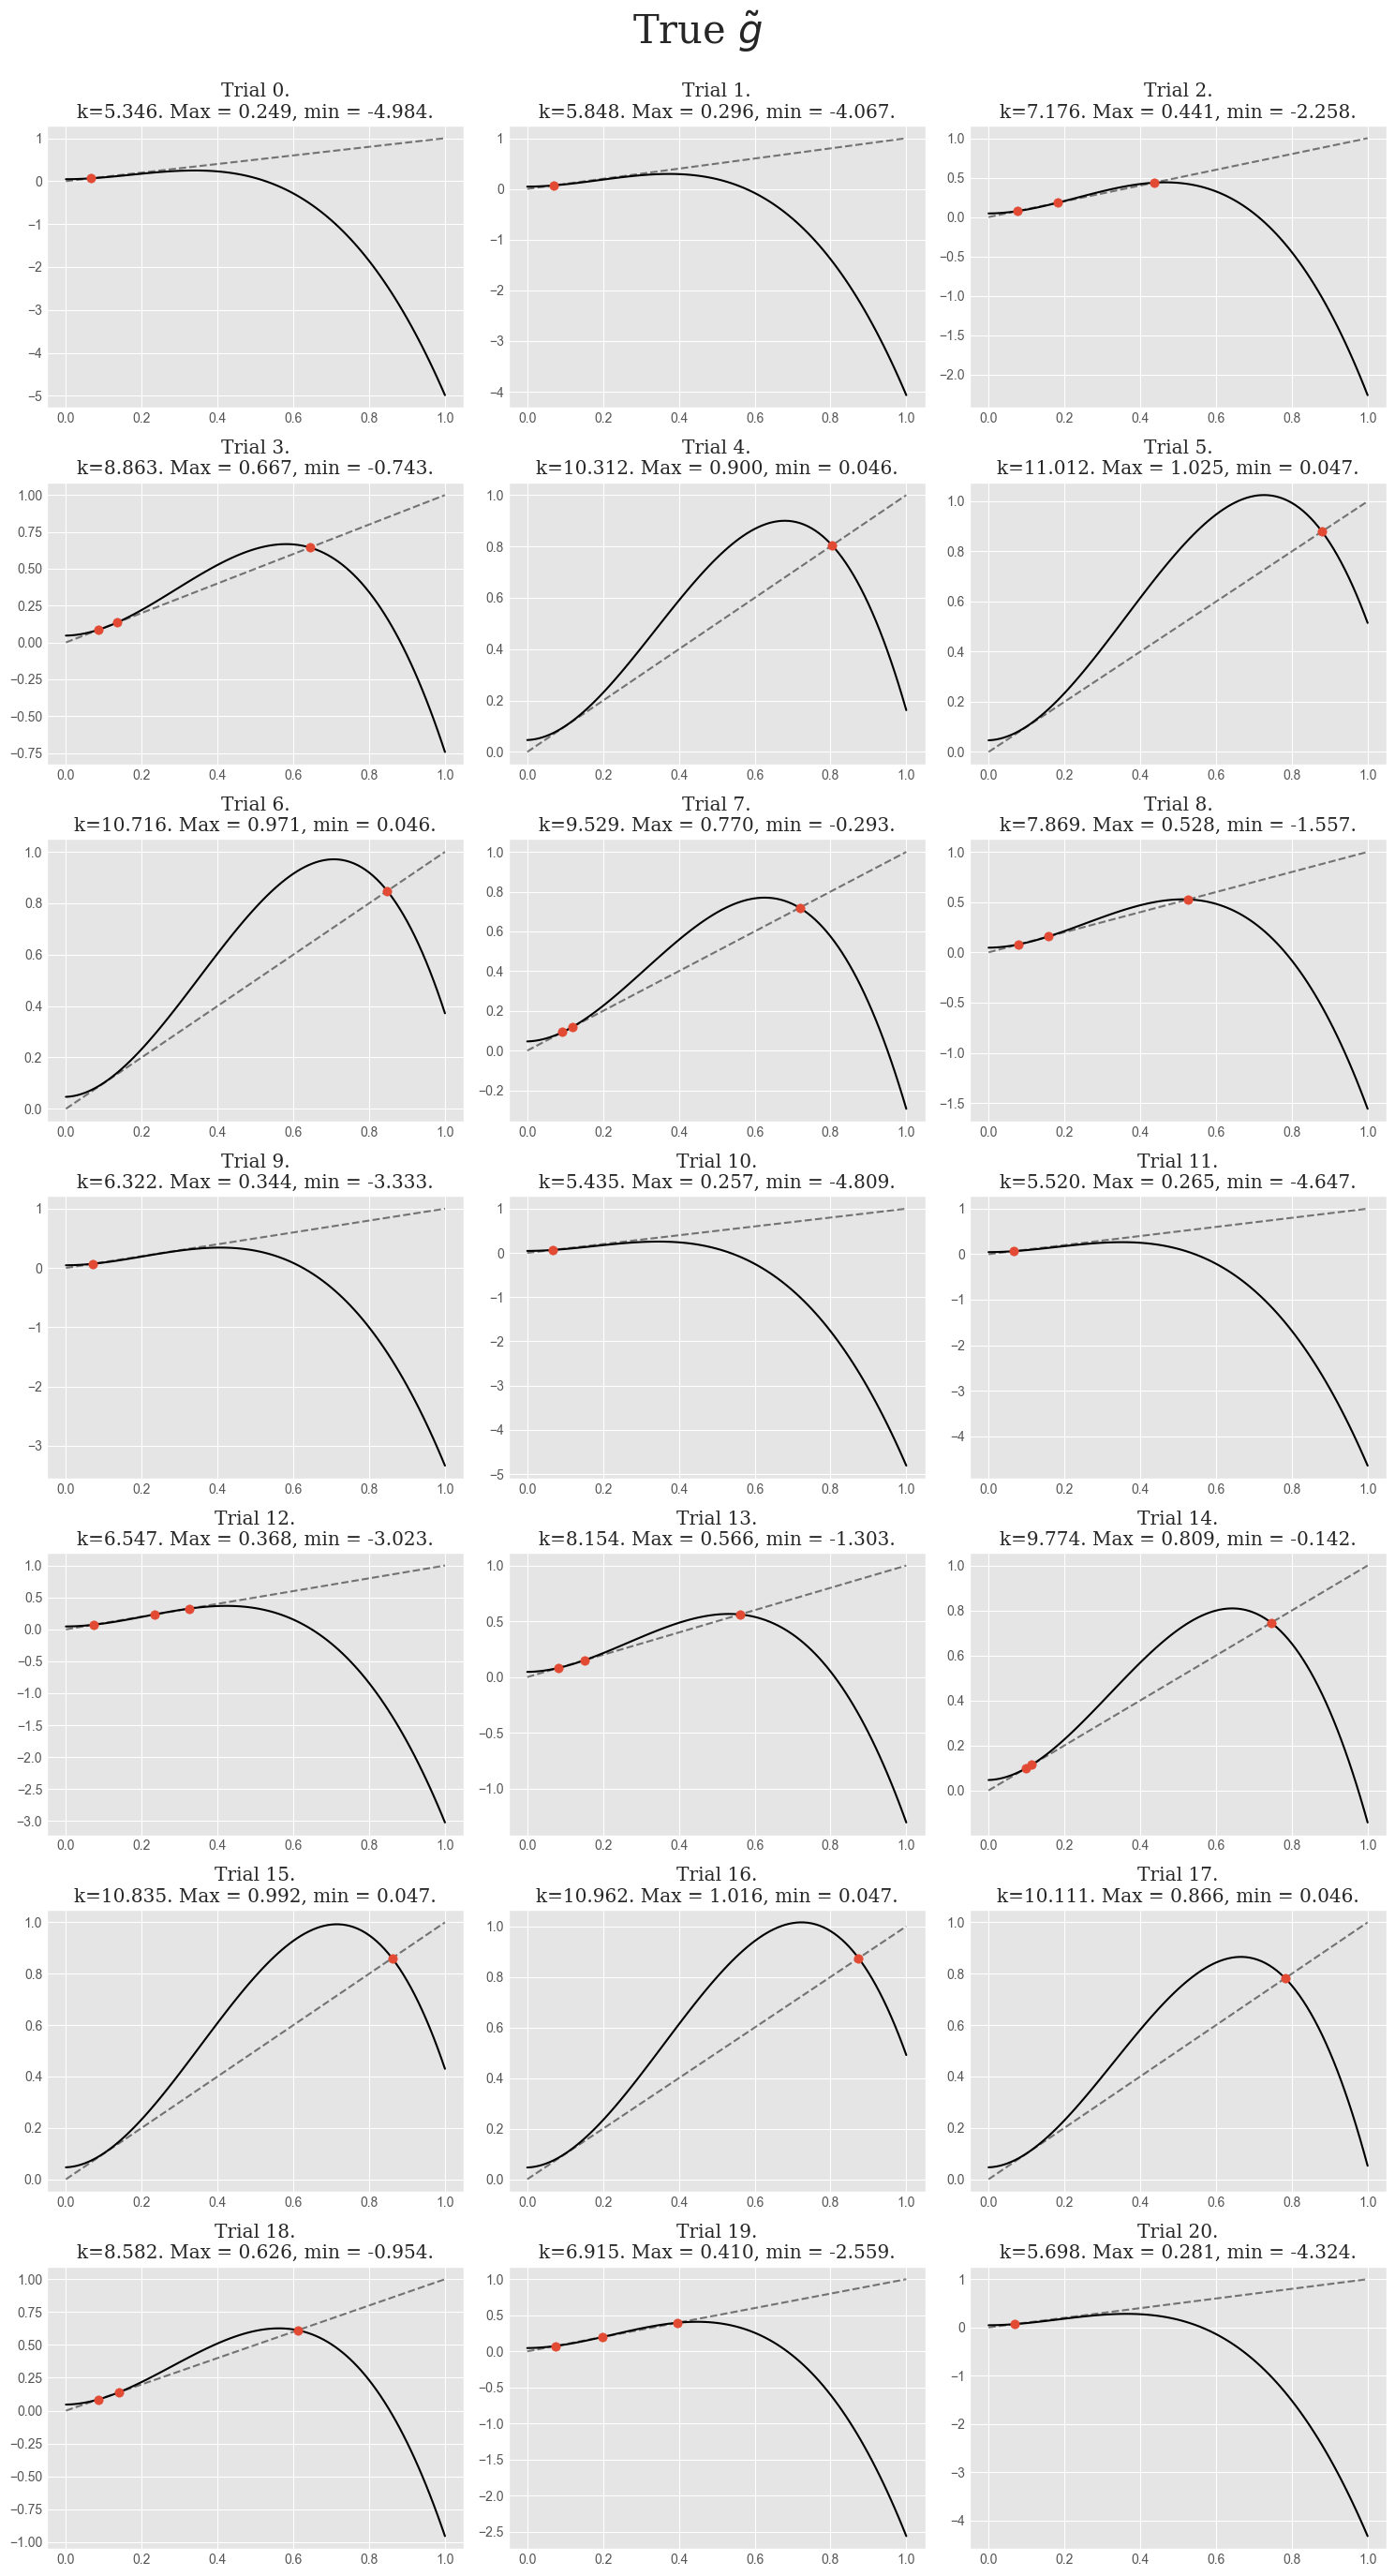

In [44]:
cols = 3
rows = int(np.ceil(len(k_trials) / cols))
precision = 3


fig, axs = plt.subplots(rows,cols, figsize = (5*cols, 4*rows))
axs = axs.flatten()

max_vals = []
min_vals = []

for idx, k_val in enumerate(k_trials):
    ax = axs[idx]

    g_tilde = scaler.transform(g_true(x_lin_unscaled,k_val,r=0.56).reshape(-1,1)).squeeze()

    max_val = np.max(g_tilde)
    min_val = np.min(g_tilde)
    max_vals.append(max_val)
    min_vals.append(min_val)



    ax.plot(x_lin, g_tilde, c='black')
    ax.plot(x_lin, x_lin, c='black', alpha=0.5, linestyle='--')

    scaled_steady_states = scaler.transform(np.array(budworm_steady_states(k_val,r=0.56)).reshape(-1,1)).reshape(-1)

    ax.scatter(scaled_steady_states, scaled_steady_states,zorder=2, s=45)


    # ax.set_ylim(-0.1, 1)
    ax.set_title(f"Trial {idx}." + f"\nk={k_val:.{precision}f}. Max = {max_val:.{precision}f}, min = {min_val:.{precision}f}.",family='serif')


plt.suptitle(r"True $\tilde g$ ", family='serif', size=30)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("true_g_scaled.pdf")
plt.show()


In [32]:
np.max(max_vals), np.min(min_vals)

(1.0250182942998904, -4.9843281829399695)

In [43]:
len(k_trials)

21